In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime

In [ ]:
# define functions

#=========== gen_null_stat(df) ===========
# input: df
# output: df_stat, df_null
def gen_null_stat(df):
    null_df = df.isnull()
    temp_seri = null_df.sum()
    null_stat = pd.DataFrame({"col": list(temp_seri.keys()), "null_count": list(temp_seri.values)})

    null_stat["percent"] = (null_stat["null_count"]/(len(df)))*100
    return null_stat, null_df


#=========== filter_outliner(col) ===========
# input: df, col_name
# output: df
def filter_outliner(df, col_name):
    arr = df[col_name].values
    q3 = np.quantile(arr, 0.75)

    q1 = np.quantile(arr, 0.25)
    iqr = q3 - q1
    upper_limit = q3 + 1.5*iqr
    lower_limit = q1 - 1.5*iqr
    df = df[(df[col_name] <= upper_limit) & (df[col_name] >= lower_limit)]
    return df

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/PTDLUD_08_ShareGV/DATH/DATH#01/Airplane_Crashes_and_Fatalities_Since_1908.csv')
df

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary
0,09/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,07/12/1912,06:30,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
2,08/06/1913,NaN,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...
3,09/09/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...
4,10/17/1913,10:30,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5263,05/20/2009,06:30,"Near Madiun, Indonesia",Military - Indonesian Air Force,NaN,Jakarta - Maduin,Lockheed C-130 Hercules,A-1325,1982,112.0,98.0,2.0,"While on approach, the military transport cras..."
5264,05/26/2009,NaN,"Near Isiro, DemocratiRepubliCongo",Service Air,NaN,Goma - Isiro,Antonov An-26,9Q-CSA,5005,4.0,4.0,NaN,The cargo plane crashed while on approach to I...
5265,06/01/2009,00:15,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,447,Rio de Janeiro - Paris,Airbus A330-203,F-GZCP,660,228.0,228.0,0.0,The Airbus went missing over the AtlantiOcean ...
5266,06/07/2009,08:30,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,NaN,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,C-FJJR,424,1.0,1.0,0.0,The air ambulance crashed into hills while att...


In [ ]:
df.info()
# => có khá nhiều cột missing data
# => có cột date và time => cần ghép lại để analyze

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5268 entries, 0 to 5267
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          5268 non-null   object 
 1   Time          3049 non-null   object 
 2   Location      5248 non-null   object 
 3   Operator      5250 non-null   object 
 4   Flight #      1069 non-null   object 
 5   Route         3562 non-null   object 
 6   Type          5241 non-null   object 
 7   Registration  4933 non-null   object 
 8   cn/In         4040 non-null   object 
 9   Aboard        5246 non-null   float64
 10  Fatalities    5256 non-null   float64
 11  Ground        5246 non-null   float64
 12  Summary       4878 non-null   object 
dtypes: float64(3), object(10)
memory usage: 535.2+ KB


In [ ]:
# Dataset này mỗi dòng là 1 tai nạn máy bay
# Dataset này có 13 cột tổng cộng
# Cột Date là ngày xảy ra tai tạn
# Cột Time là giờ: phút xảy ra tai nạn
# Cột Location cho biết địa điểm xảy ra tai nạn
# Cột Operator là máy bay đó thuộc về tổ chức/cá nhân nào (airline,...)
# Cột Flight# là số hiệu chuyến bay
# Cột Route là tập hợp điểm đến và đi của chuyến bay (không theo thứ tự)
# Cột Type là loại máy bay (A320, A350,...) dùng trong chuyến bay này
# Cột Registration là ICAO Aircraft Registration 
# Cột cn/In là serial number của máy bay
# Cột Aboard là tổng số người trên máy bay của chuyến bay này
# Cột Fatalities là tổng số thiệt mạng trong tai nạn này (trên máy bay)
# Cột Ground là số người thiệt mạng dưới đất khi xảy ra tai nạn (những người không trên máy bay)
# Cột Summary là description cho tai nạn này

#CLEAN AND MERGE DATE AND TIME COLUMN

In [ ]:
def is_correct_date_time_value(value, format):
    try:
        datetime.datetime.strptime(value, format)
        return True
    except ValueError:
        return False


In [ ]:
# CHECK FORMAT CỘT DATE VÀ CỘT TIME
df["Time"] = df["Time"].fillna("00:00")
df["DateTime"] = df["Date"] +" "+ df["Time"]

# select ra những dòng sai format
is_not_date = [not(is_correct_date_time_value(i, "%m/%d/%Y %H:%M")) for i in df["DateTime"]]
check = df[is_not_date]
check

,Date,Time,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,DateTime
190,09/03/1929,c: 1:00,"Mt. Taylor, New Mexico",Trans Continental Air Transport,NaN,Albuquerque - Los Angeles,Ford 5-AT-B Tri Motor,NC9649,5-AT-002,8.0,8.0,0.0,Crashed in a thunderstorm after being struck b...,09/03/1929 c: 1:00
213,04/18/1930,c:17:00,"Jersey City, New Jersey",Canadian Colonial Airways,NaN,"Albany, NY - Jersey City, NJ",Fairchild 71,NaN,634,4.0,4.0,0.0,Crashed into power lines 150 feet above the gr...,04/18/1930 c:17:00
228,11/18/1930,c: 2:00,"Techachapi Mountains, California",PacifiAir Transport,NaN,"Burbank, CA - Oakland, CA",Boeing 40,NC5340,NaN,3.0,3.0,NaN,Crashed into a mountainside at an altitude of ...,11/18/1930 c: 2:00
279,09/08/1932,c:09:00,"Salt Flats, Texas",American Airways,NaN,El Paso - Dallas,Fokker F-10,NC9716,NaN,4.0,3.0,0.0,The mail plane struck a mountain and burned en...,09/08/1932 c:09:00
1462,01/23/1957,c16:50,"Ometepe Island, Nicaragua",Lanica,NaN,San Carlos - Managua,Douglas DC-3,AN-AEC,12312,16.0,16.0,0.0,The aircraft hit Concepcion volcano while en r...,01/23/1957 c16:50
1710,01/28/1961,12'20,"Off Montauk Point, New York",American Airlines,NaN,Training,Boeing 707-123,N7502A,17629/8,6.0,6.0,0.0,Crashed into the AtlantiOcean and exploded.,01/28/1961 12'20
1949,12/21/1964,18.40,"Near Kaliba, Philippines",Fleming Airways System Transport,NaN,Kalibo - Manila,Douglas DC-3,PI-C569,20396,39.0,1.0,0.0,After losing the No. 1 engine the pilot decide...,12/21/1964 18.40
2599,10/21/1972,c:09:00,"Off Athens, Greece",OlympiAirways,NaN,Kerkira - Athens,NAMC YS-11A-202,SX-BBQ,2155,53.0,37.0,0.0,Crashed into the sea just short of the runway ...,10/21/1972 c:09:00
3267,02/22/1981,114:20,"Avalon, California",Helicopter - Air Taxi,NaN,"San Pedro, CA - Avalon, CA",Sikorsky S-62A,N324Y,62012,8.0,2.0,0.0,The main rotor disk failed from a fatigue frac...,02/22/1981 114:20
3390,12/09/1982,c14:30,"Near San Andres de Bocay, Nicaragua",Military - Nicaraguan Air Force,NaN,NaN,Mil Mi-8 (helicopter),265,NaN,88.0,84.0,0.0,Shot down by Sandinistan rebels.,12/09/1982 c14:30


In [ ]:
len(check)
# Chỉ có 13 dòng bị sai trên tổng cộng 5268 => có thể bỏ 13 dòng này vì quá ít

13

In [ ]:
df = df.drop(check.index)
df = df.drop(columns=["Date", "Time"])
df

,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,DateTime
0,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",09/17/1908 17:18
1,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,07/12/1912 06:30
2,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...,08/06/1913 00:00
3,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...,09/09/1913 18:30
4,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...,10/17/1913 10:30
...,...,...,...,...,...,...,...,...,...,...,...,...
5263,"Near Madiun, Indonesia",Military - Indonesian Air Force,NaN,Jakarta - Maduin,Lockheed C-130 Hercules,A-1325,1982,112.0,98.0,2.0,"While on approach, the military transport cras...",05/20/2009 06:30
5264,"Near Isiro, DemocratiRepubliCongo",Service Air,NaN,Goma - Isiro,Antonov An-26,9Q-CSA,5005,4.0,4.0,NaN,The cargo plane crashed while on approach to I...,05/26/2009 00:00
5265,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,447,Rio de Janeiro - Paris,Airbus A330-203,F-GZCP,660,228.0,228.0,0.0,The Airbus went missing over the AtlantiOcean ...,06/01/2009 00:15
5266,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,NaN,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,C-FJJR,424,1.0,1.0,0.0,The air ambulance crashed into hills while att...,06/07/2009 08:30


In [ ]:
df["DateTime"] = pd.to_datetime(df["DateTime"])
df

,Location,Operator,Flight #,Route,Type,Registration,cn/In,Aboard,Fatalities,Ground,Summary,DateTime
0,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,0.0,"During a demonstration flight, a U.S. Army fly...",1908-09-17 17:18:00
1,"AtlantiCity, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...,1912-07-12 06:30:00
2,"Victoria, British Columbia, Canada",Private,-,NaN,Curtiss seaplane,NaN,NaN,1.0,1.0,0.0,The first fatal airplane accident in Canada oc...,1913-08-06 00:00:00
3,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,14.0,0.0,The airship flew into a thunderstorm and encou...,1913-09-09 18:30:00
4,"Near Johannisthal, Germany",Military - German Navy,NaN,NaN,Zeppelin L-2 (airship),NaN,NaN,30.0,30.0,0.0,Hydrogen gas which was being vented was sucked...,1913-10-17 10:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...
5263,"Near Madiun, Indonesia",Military - Indonesian Air Force,NaN,Jakarta - Maduin,Lockheed C-130 Hercules,A-1325,1982,112.0,98.0,2.0,"While on approach, the military transport cras...",2009-05-20 06:30:00
5264,"Near Isiro, DemocratiRepubliCongo",Service Air,NaN,Goma - Isiro,Antonov An-26,9Q-CSA,5005,4.0,4.0,NaN,The cargo plane crashed while on approach to I...,2009-05-26 00:00:00
5265,"AtlantiOcean, 570 miles northeast of Natal, Br...",Air France,447,Rio de Janeiro - Paris,Airbus A330-203,F-GZCP,660,228.0,228.0,0.0,The Airbus went missing over the AtlantiOcean ...,2009-06-01 00:15:00
5266,"Near Port Hope Simpson, Newfoundland, Canada",Strait Air,NaN,Lourdes de BlanSablon - Port Hope Simpson,Britten-Norman BN-2A-27 Islander,C-FJJR,424,1.0,1.0,0.0,The air ambulance crashed into hills while att...,2009-06-07 08:30:00


In [ ]:
df.describe()
# Do dataset chỉ có 3 cột số nên ta chỉ xem xét 3 cột này
# Đối với cả 3 cột giá trị min là 0 => không có số âm => không cần làm sạch

# Cột Aboad có giá trị trung bình là 27.46 nhưng độ lệch chuẩn rất lớn 43.056 cho thấy dữ liệu phân phối không tập trung xung quanh mean, khi nhìn vào các giá trị 25% là 5, 50% là 13 và 75% là 30.
# Ta có thể kết luận có 75% chuyến bay có <= 30 người trên máy bay, nhung max tới 644

# Cột Fatalities có giá trị trung bình là 33.2 nhưng độ lệch chuẩn rất lớn 20.04 cho thấy dữ liệu phân phối không tập trung xung quanh mean, khi nhìn vào các giá trị 25% là 3, 50% là 9 và 75% là 23.
# Ta có thể kết luận có 75% chuyến bay bị tai nạn có <= 23 người chết, nhung max tới 538 

# Cột Ground có giá trị trung bình là 1.6 nhưng độ lệch chuẩn rất lớn 53.94 cho thấy dữ liệu phân phối không tập trung xung quanh mean, khi nhìn vào các giá trị 25%, 50% và 75% đều bằng 0.
# Ta có thể kết luận 75% chuyến bay bị tai nạn thì không có thương vong dưới đất, nhung max tới 2750 

,Aboard,Fatalities,Ground
count,5233.000000,5243.000000,5234.000000
mean,27.577298,20.084875,1.612533
std,43.109625,33.220665,54.049637
min,0.000000,0.000000,0.000000
25%,5.000000,3.000000,0.000000
50%,13.000000,9.000000,0.000000
75%,30.000000,23.000000,0.000000
max,644.000000,583.000000,2750.000000


In [ ]:
print("Total row: " + str(len(df)))
print("Total row after drop duplicated: " + str(len(df.drop_duplicates())))

Total row: 5255
Total row after drop duplicated: 5255


In [ ]:
# Không có duplicate vì total row = total row sau khi drop duplicates

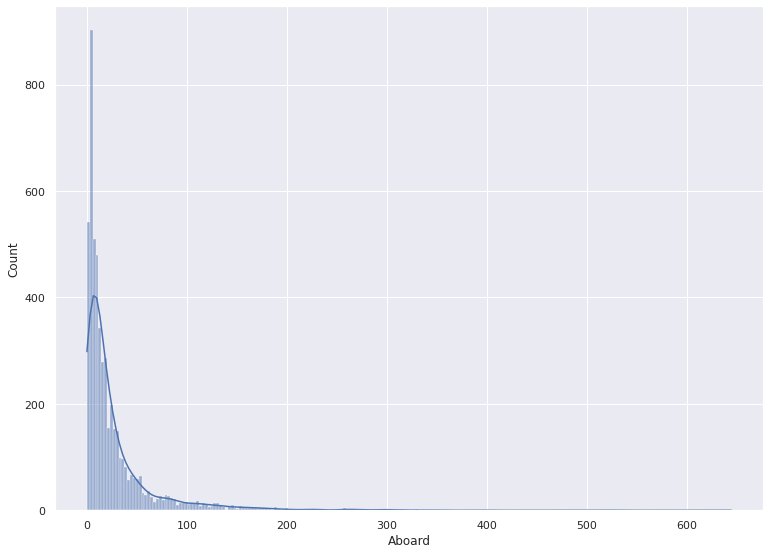

In [ ]:
# HISTOGRAM
sns.set(rc={'figure.figsize':(12.7,9.27)})
sns.histplot(data=df, x="Aboard",kde=True)

In [ ]:
# Phân phối của số lượng nguồi trên máy bay không đều, Biểu đồ lệch phải, phân phối khá răng cưa, trượt dài từ đầu đỉnh là tầm 10 xuống. Dữ liệu tập trung ở phan khúc 0-30. Xong rồi giảm mạnh trở đi.
# Ta thấy còn có những dữ liệu >600 và những dữ liệu tầm 300-400 trở đi. 

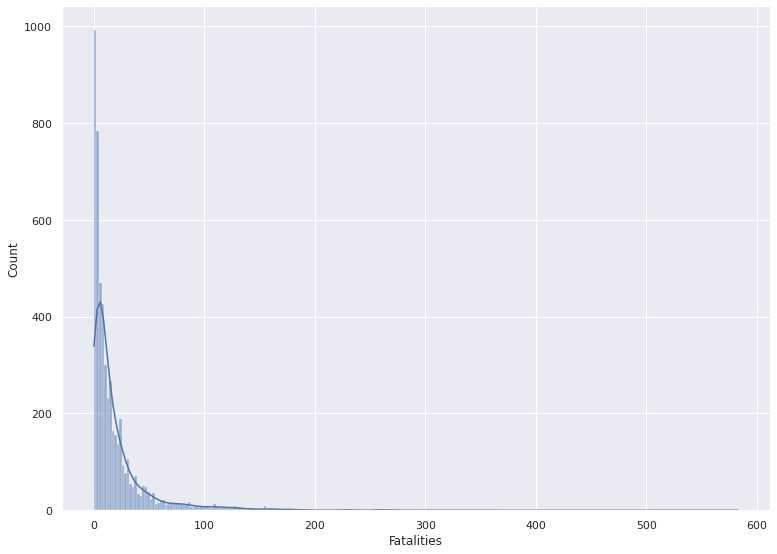

In [ ]:
sns.histplot(data=df, x="Fatalities", kde=True)

In [ ]:
# Phân phối của số lượng thiệt mạng trong những tai nạn máy bay phân phối không đều, lệch phải, biểu đồ khá răng cưa và trượt dài từ đỉnh là 0 xuống. Dữ liệu tập trung nhiều ở khúc 0-30. 
# Ta cũng có thể thấy được có dữ liệu có giá trị >300 và tới >600, có thể là điểm dị biệt do số lượng người thiệt mạng không thể lớn thế được

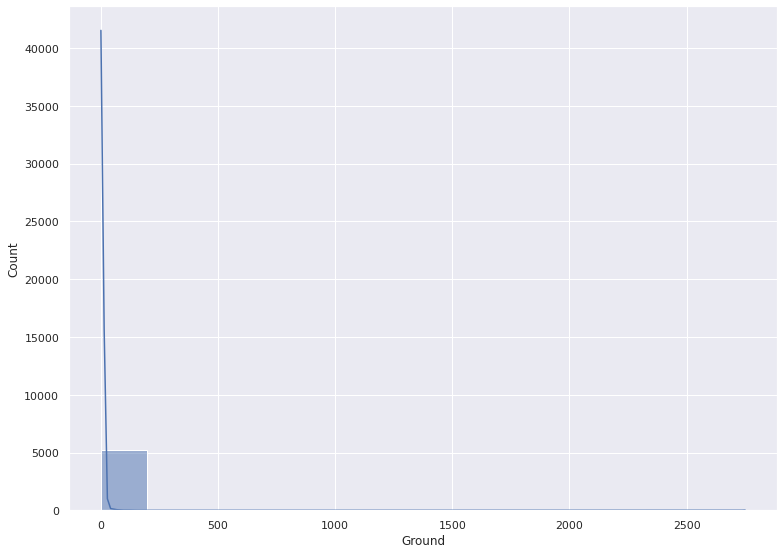

In [ ]:
sns.histplot(data=df, x="Ground", kde=True)

In [ ]:
# Phân phối của số lượng người thiệt mạng dưới đất gần như toàn bộ là 0, tập trung xung quanh 0. nhưng có rất nhiều điểm dị biệt số lượng người thiệt mạng nhiều hơn 1000

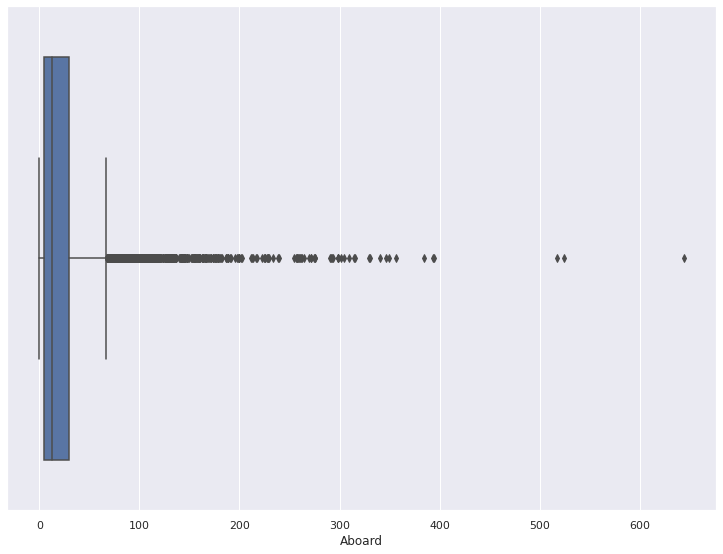

In [ ]:
# BOX PLOT
sns.boxplot(x=df["Aboard"])

In [ ]:
# Ta thấy khoảng IQR trong khoảng 0 đến tầm 75 người, dữ liệu tập trung trong khoảng 5 cho đến 20, biểu đồ lệch phải. Có rất nhiều điểm dị biệt trong từ 75 trở đi -> CÁCH XỬ LÝL bỏ những điểm có giá trị > 350

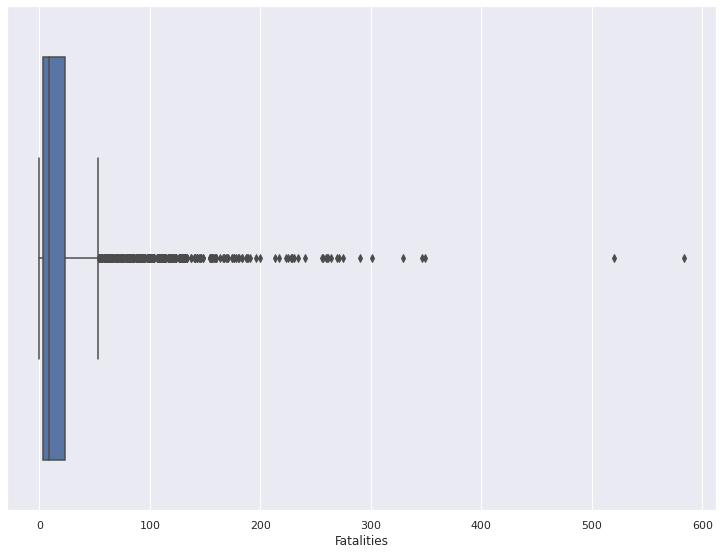

In [ ]:
sns.boxplot(x=df["Fatalities"])

In [ ]:
# Ta thấy khoảng IQR trong khoảng 0 đến tầm 50 người, dữ liệu tập trung trong khoảng 5 cho đến 20, biểu đồ lệch phải. Có rất nhiều điểm dị biệt từ 50 trở đi -> CÁCH XỬ LÝL bỏ những điểm có giá trị > 250

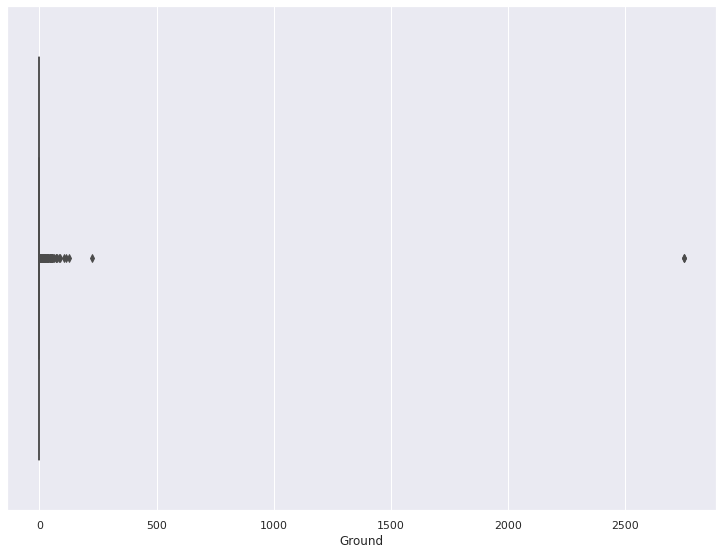

In [ ]:
sns.boxplot(x=df["Ground"])

In [ ]:
# Ta thấy giá trị của Ground phần lớn bằng 0 tức là đa số chuyến bay tai nạn đều không có thương vong dưới đất. nhưng có 1 số điểm dị biệt từ 0 trở đi và có 1 điểm dị biệt > 2500 -> CÁCH XỬ LÝL bỏ những điểm có giá trị > 200

In [ ]:
# Đánh giá sơ bộ tinh chất phân phối của các biến: 
# + Các biến phân phối phần lớn đều bị lệch hẳn về 1 phía 
# + Giá trị trong dữ liệu có sự chênh lệch rất lớn với nhau

# CORRELATION HEATMAP

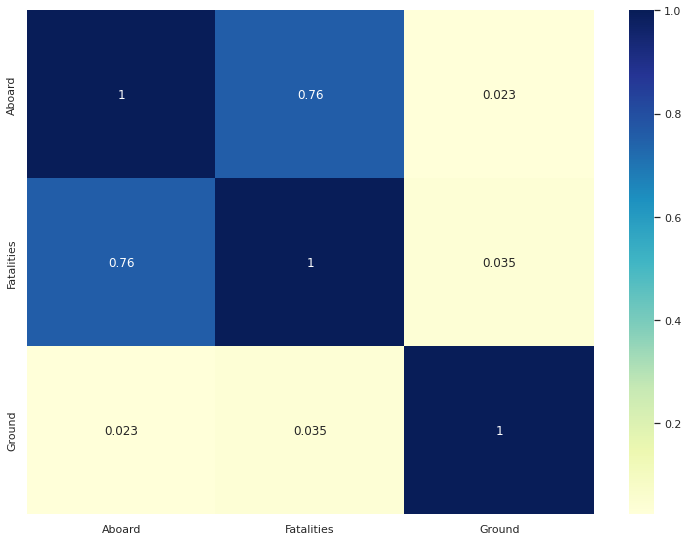

In [ ]:
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)

In [ ]:
# Như ta thấy càng nhiều người lên 1 chuyến bay thì lượng người thiệt mạng trong 1 tai nạn càng lớn => dễ dàng đoán
# Các biến khác ta thấy không có quan hệ gì với nhau

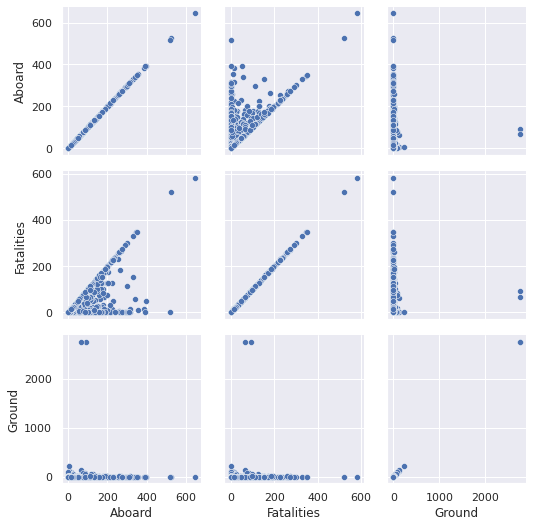

In [ ]:
g = sns.PairGrid(df)
g.map(sns.scatterplot)

In [ ]:
# Như biểu đồ trên, các biến rất ít liên hệ với nhau

# CLEAN



In [ ]:
# get string column
string_col = df.select_dtypes(include=["object"]).columns
string_col

Index(['Location', 'Operator', 'Flight #', 'Route', 'Type', 'Registration',
       'cn/In', 'Summary'],
      dtype='object')

In [ ]:
# tính stat null của từng cột trong data hiện tại
null_stat, null_df = gen_null_stat(df)
null_stat

,col,null_count,percent
0,Location,20,0.380590
1,Operator,18,0.342531
2,Flight #,4187,79.676499
3,Route,1704,32.426261
4,Type,27,0.513796
5,Registration,334,6.355852
6,cn/In,1224,23.292103
7,Aboard,22,0.418649
8,Fatalities,12,0.228354
9,Ground,21,0.399619


In [ ]:
# Như trên ta thấy được rằng cột Flight# có tới 80% null => drop cột này
# Đối với các cột Route, cn/In(seri của máy bay), Registration và Summary đều có null khá cao, cộng với các cột này không có ý nghĩa thống kê => drop
# Đối với những cột có quá ít null (<5%) => drop na cho những cột này
# Đối vói những cốt có khá nhiều null (>5%) => trương trường hợp này, null chủ yếu cột string => thay vào Unknown

In [ ]:
# drop cột Flight #, Route, cn/In, Summary,Registration
df = df.drop(["Flight #","Route", "cn/In","Summary", "Registration"], axis=1)
df.head()

,Location,Operator,Type,Aboard,Fatalities,Ground,DateTime
0,"Fort Myer, Virginia",Military - U.S. Army,Wright Flyer III,2.0,1.0,0.0,1908-09-17 17:18:00
1,"AtlantiCity, New Jersey",Military - U.S. Navy,Dirigible,5.0,5.0,0.0,1912-07-12 06:30:00
2,"Victoria, British Columbia, Canada",Private,Curtiss seaplane,1.0,1.0,0.0,1913-08-06 00:00:00
3,Over the North Sea,Military - German Navy,Zeppelin L-1 (airship),20.0,14.0,0.0,1913-09-09 18:30:00
4,"Near Johannisthal, Germany",Military - German Navy,Zeppelin L-2 (airship),30.0,30.0,0.0,1913-10-17 10:30:00


In [ ]:
# drop những cột có % null < 5
null_smaller_than_one = null_stat[(null_stat["percent"] < 5) & (null_stat["percent"] > 0)]["col"]

df_temp = df.copy()
for col in null_smaller_than_one:
     df_temp = df_temp[~df_temp[col].isna()]

print("Dropped " + str(len(df) - len(df_temp)) + " rows")
# => Drop chỉ 86 rows => ok
df = df_temp.copy()

Dropped 86 rows


In [ ]:
# replace những cột string có giá trị null thành Unknown
null_greater_than_one = null_stat[(null_stat["percent"] > 5)]["col"]


df_temp = df.copy()
replaced_dict = {}
for col in null_greater_than_one:
    if col in string_col:
        replaced_dict[col] = "Unknown"
    else:
        replaced_dict[col] = np.mean(df[col])

df_temp = df_temp.fillna(value=replaced_dict)
df_temp

# tính stat null của từng cột trong data hiện tại
null_stat, null_df = gen_null_stat(df)
null_stat

,col,null_count,percent
0,Location,0,0.0
1,Operator,0,0.0
2,Type,0,0.0
3,Aboard,0,0.0
4,Fatalities,0,0.0
5,Ground,0,0.0
6,DateTime,0,0.0


In [ ]:
temp = df['Location'].value_counts()
print(temp)
print("Value count bigger than 1: " + str(len(temp[temp > 1])))

# cột location có 3609 distinct value nhưng chỉ có 348 giá trị có số lần xuất hiện nhiều hơn 1, max số lần xuất hiện cũng chỉ là 12 => cột này đa số là giá trị distinct => drop
df = df.drop('Location', axis = 1)

Sao Paulo, Brazil       15
Moscow, Russia          14
Bogota, Colombia        13
Manila, Philippines     13
Anchorage, Alaska       13
                        ..
Near Houma Louisiana     1
Tbilisi, Georgia         1
Near Bogota Colombia     1
Mason City, Iowa         1
Wyndham, Australia       1
Name: Location, Length: 4246, dtype: int64
Value count bigger than 1: 458


In [ ]:
temp = df['Type'].value_counts()
print(temp)
print("Value count bigger than 1: " + str(len(temp[temp > 1])))

# cột Type có 1986 distinct value, số lượng giá trị lặp lại là 533

Douglas DC-3                                329
de Havilland Canada DHC-6 Twin Otter 300     81
Douglas C-47A                                73
Douglas C-47                                 60
Douglas DC-4                                 40
                                           ... 
Sikorsky S-76A                                1
Sepecat Jaguar A                              1
Tupolev ANT-20 / I-5                          1
NAMC YS-11A-500                               1
Consolidated 32-2 Liberator II                1
Name: Type, Length: 2418, dtype: int64
Value count bigger than 1: 651


In [ ]:
temp = df['Operator'].value_counts()
print(temp)
print("Value count bigger than 1: " + str(len(temp[temp > 1])))

# cột Operator có 2212 distinct value, số lượng giá trị lặp lại là 466 => giữ

Aeroflot                     176
Military - U.S. Air Force    174
Air France                    67
Deutsche Lufthansa            62
Air Taxi                      44
                            ... 
SceniAir Lines                 1
Henry Nichols - Air Taxi       1
West Air                       1
Oefag Flugdienst               1
Bharat Airways                 1
Name: Operator, Length: 2463, dtype: int64
Value count bigger than 1: 545


Outliner

In [ ]:
# drop outliner
df_temp = df.copy()
for col in df_temp.describe().columns:
    df_temp = filter_outliner(df_temp, col)

drop=len(df) - len(df_temp)
print("Number of OUTLINERS dropped: " + str(drop) + "/ " + str(drop/len(df)))

# Số lượng data drop không nhiều => 17.8% => Chấp nhận drop
df = df_temp.copy()

Number of OUTLINERS dropped: 917/ 0.17740375314374154


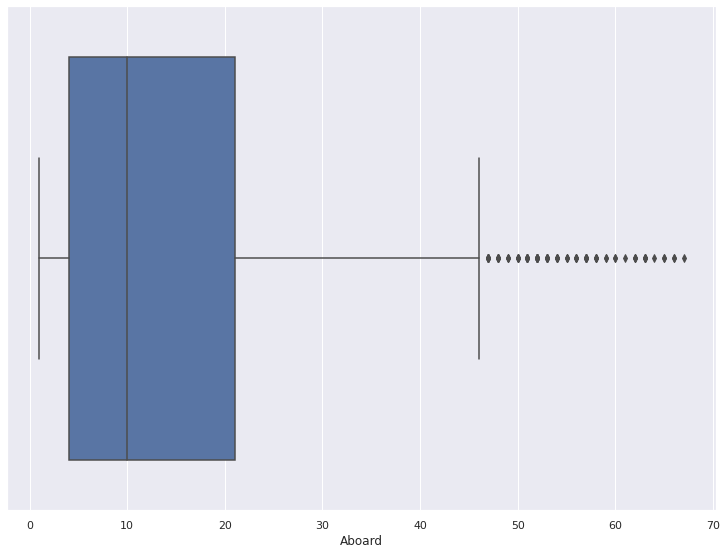

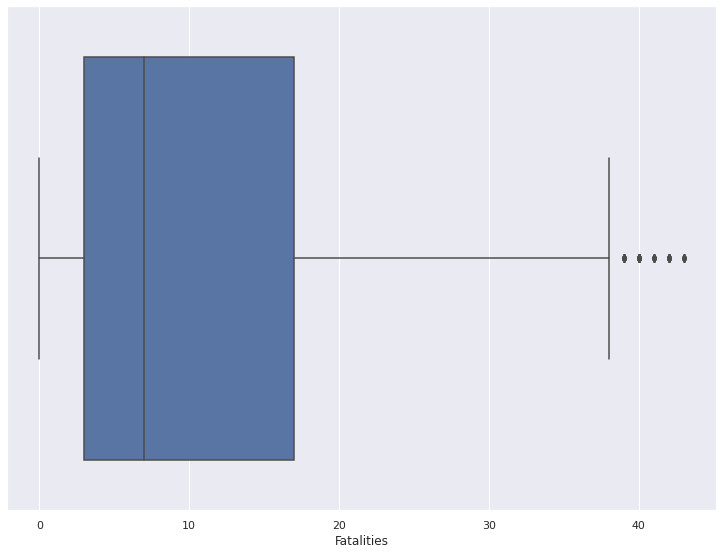

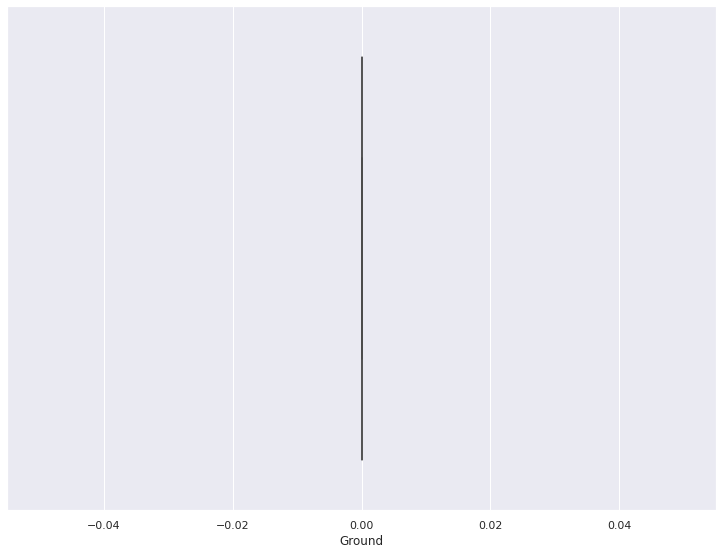

In [ ]:
# draw box plot
for i, col in enumerate(df.describe().columns):
    plt.figure(i)
    sns.boxplot(x = df[col])


In [ ]:
df["Ground"].describe()
# drop cột ground do sau khi drop outliner chỉ còn 1 giá trị 0 
df = df.drop("Ground", axis=1)

Split datetime to day, month, hour, minute, second and milisecond

In [ ]:
df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['Minute'] = df['DateTime'].dt.minute
df['Second'] = df['DateTime'].dt.second
df = df.drop('DateTime', axis=1)
df

,Operator,Type,Aboard,Fatalities,Year,Month,Day,Hour,Minute,Second
0,Military - U.S. Army,Wright Flyer III,2.0,1.0,1908,9,17,17,18,0
1,Military - U.S. Navy,Dirigible,5.0,5.0,1912,7,12,6,30,0
2,Private,Curtiss seaplane,1.0,1.0,1913,8,6,0,0,0
3,Military - German Navy,Zeppelin L-1 (airship),20.0,14.0,1913,9,9,18,30,0
4,Military - German Navy,Zeppelin L-2 (airship),30.0,30.0,1913,10,17,10,30,0
...,...,...,...,...,...,...,...,...,...,...
5260,Aerotuy airline,Cessna 208B Grand Caravan,11.0,1.0,2009,4,17,15,32,0
5261,Bako Air,Boeing B-737-200,7.0,7.0,2009,4,29,6,0,0
5262,Military - Venezuelan Army,Mi-35,18.0,18.0,2009,5,3,12,0,0
5266,Strait Air,Britten-Norman BN-2A-27 Islander,1.0,1.0,2009,6,7,8,30,0


In [ ]:
df['Second'].describe()

# => cột second toàn bộ giá trị 0 => drop

df = df.drop('Second', axis=1)

In [ ]:
# gen nhãn cho từng dòng:
#        fatalities > 50 -> High 
#        4 < fatalities < 28 -> Medium
#        fatalities < 4 -> Low


df["y"] = np.where(
    df["Fatalities"].between(0, 4, "neither"),
    "Low",
    np.where(
        df["Fatalities"].between(4, 28, "left"),
        "Medium",
        "High"
    )
)
df

,Operator,Type,Aboard,Fatalities,Year,Month,Day,Hour,Minute,y
0,Military - U.S. Army,Wright Flyer III,2.0,1.0,1908,9,17,17,18,Low
1,Military - U.S. Navy,Dirigible,5.0,5.0,1912,7,12,6,30,Medium
2,Private,Curtiss seaplane,1.0,1.0,1913,8,6,0,0,Low
3,Military - German Navy,Zeppelin L-1 (airship),20.0,14.0,1913,9,9,18,30,Medium
4,Military - German Navy,Zeppelin L-2 (airship),30.0,30.0,1913,10,17,10,30,High
...,...,...,...,...,...,...,...,...,...,...
5260,Aerotuy airline,Cessna 208B Grand Caravan,11.0,1.0,2009,4,17,15,32,Low
5261,Bako Air,Boeing B-737-200,7.0,7.0,2009,4,29,6,0,Medium
5262,Military - Venezuelan Army,Mi-35,18.0,18.0,2009,5,3,12,0,Medium
5266,Strait Air,Britten-Norman BN-2A-27 Islander,1.0,1.0,2009,6,7,8,30,Low


In [ ]:
df

,Operator,Type,Aboard,Fatalities,Year,Month,Day,Hour,Minute,y
0,Military - U.S. Army,Wright Flyer III,2.0,1.0,1908,9,17,17,18,Low
1,Military - U.S. Navy,Dirigible,5.0,5.0,1912,7,12,6,30,Medium
2,Private,Curtiss seaplane,1.0,1.0,1913,8,6,0,0,Low
3,Military - German Navy,Zeppelin L-1 (airship),20.0,14.0,1913,9,9,18,30,Medium
4,Military - German Navy,Zeppelin L-2 (airship),30.0,30.0,1913,10,17,10,30,High
...,...,...,...,...,...,...,...,...,...,...
5260,Aerotuy airline,Cessna 208B Grand Caravan,11.0,1.0,2009,4,17,15,32,Low
5261,Bako Air,Boeing B-737-200,7.0,7.0,2009,4,29,6,0,Medium
5262,Military - Venezuelan Army,Mi-35,18.0,18.0,2009,5,3,12,0,Medium
5266,Strait Air,Britten-Norman BN-2A-27 Islander,1.0,1.0,2009,6,7,8,30,Low


label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

for col in ['Type', 'Operator', 'y']:
    df[col] = enc.fit_transform(df[col])

df

,Operator,Type,Aboard,Fatalities,Year,Month,Day,Hour,Minute,y
0,1394,1885,2.0,1.0,1908,9,17,17,18,1
1,1405,809,5.0,5.0,1912,7,12,6,30,2
2,1624,774,1.0,1.0,1913,8,6,0,0,1
3,1310,1896,20.0,14.0,1913,9,9,18,30,2
4,1310,1898,30.0,30.0,1913,10,17,10,30,0
...,...,...,...,...,...,...,...,...,...,...
5260,121,596,11.0,1.0,2009,4,17,15,32,1
5261,486,395,7.0,7.0,2009,4,29,6,0,2
5262,1417,1525,18.0,18.0,2009,5,3,12,0,2
5266,1898,492,1.0,1.0,2009,6,7,8,30,1


standard scaler

In [ ]:
df

,Operator,Type,Aboard,Fatalities,Year,Month,Day,Hour,Minute,y
0,1394,1885,2.0,1.0,1908,9,17,17,18,1
1,1405,809,5.0,5.0,1912,7,12,6,30,2
2,1624,774,1.0,1.0,1913,8,6,0,0,1
3,1310,1896,20.0,14.0,1913,9,9,18,30,2
4,1310,1898,30.0,30.0,1913,10,17,10,30,0
...,...,...,...,...,...,...,...,...,...,...
5260,121,596,11.0,1.0,2009,4,17,15,32,1
5261,486,395,7.0,7.0,2009,4,29,6,0,2
5262,1417,1525,18.0,18.0,2009,5,3,12,0,2
5266,1898,492,1.0,1.0,2009,6,7,8,30,1


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_no_y = df.copy()
df_no_y = df_no_y.drop("y", axis=1)
scaler.fit(df_no_y)
scaled_feature = scaler.transform(df_no_y)

df_scale = pd.DataFrame(scaled_feature, columns=df_no_y.columns)
df_scale


,Operator,Type,Aboard,Fatalities,Year,Month,Day,Hour,Minute
0,0.478197,1.657353,-0.980464,-0.984595,-2.707627,0.675986,0.141473,1.293246,0.212107
1,0.495654,-0.353301,-0.737505,-0.590405,-2.533345,0.113942,-0.430227,-0.123792,0.867503
2,0.843218,-0.418704,-1.061450,-0.984595,-2.489775,0.394964,-1.116266,-0.896722,-0.770987
3,0.344885,1.677908,0.477290,0.296523,-2.489775,0.675986,-0.773246,1.422067,0.867503
4,0.344885,1.681646,1.287153,1.873285,-2.489775,0.957008,0.141473,0.391494,0.867503
...,...,...,...,...,...,...,...,...,...
4247,-1.542116,-0.751321,-0.251587,-0.984595,1.692985,-0.729123,0.141473,1.035602,0.976736
4248,-0.962843,-1.126918,-0.575532,-0.393310,1.692985,-0.729123,1.513551,-0.123792,-0.770987
4249,0.514699,0.984644,0.315317,0.690714,1.692985,-0.448102,-1.459285,0.649137,-0.770987
4250,1.278069,-0.945660,-1.061450,-0.984595,1.692985,-0.167080,-1.001926,0.133851,0.867503


In [ ]:
# Nhìn vào dữ liệu trên ta thấy, các cột Year Month Day Hour Minute Second là dữ liệu về thời gian 
# => Sẽ không được sử dụng để phục vụ cho việc phân tích
# Các cột Operator và Type là dữ liệu về tổ chức và loại máy bay của chiếc máy bay xảy ra tai nạn
# => Sẽ không được sử dụng để phục vụ cho việc phân tích
# Đối với các cột Aboard, Fatalities, Ground có thể sử dụng phục vụ cho việc phân tích
# Đối với 3 cột trên, ta thực hiện phân tích: Dựa vào tổng số người trên máy bay, số lượng người chết trên máy bay và dưới mặt đất trong vụ tai nạn
# mà chúng ta có thể xác định được mức độ thương vong của vụ tai nạn.
# Mức độ thương vong là thuộc tính chưa tồn tại và chưa được gán nhãn
# => Học máy không giám sát (Unsupervised machine learning)


In [ ]:
df_temp = df_scale.drop(['Operator', 'Type', 'Year', 'Month', 'Day', 'Hour', 'Minute'], axis = 1)
df_temp 

,Aboard,Fatalities
0,-0.980464,-0.984595
1,-0.737505,-0.590405
2,-1.061450,-0.984595
3,0.477290,0.296523
4,1.287153,1.873285
...,...,...
4247,-0.251587,-0.984595
4248,-0.575532,-0.393310
4249,0.315317,0.690714
4250,-1.061450,-0.984595


In [ ]:
df_temp.describe()

,Aboard,Fatalities
count,4.252000e+03,4.252000e+03
mean,-5.472946e-16,1.214535e-16
std,1.000118e+00,1.000118e+00
min,-1.061450e+00,-1.083143e+00
25%,-8.184914e-01,-7.875000e-01
50%,-3.325735e-01,-3.933097e-01
75%,5.582762e-01,5.921663e-01
max,4.283647e+00,3.154404e+00


In [ ]:
# Vì số lượng người chết dưới mặt đất trong dữ liệu đều là 0 nên ta sẽ đổi tên cột này thành Causualty thay vì drop cột và thêm cột mới vào
# Bài toán sẽ chuyển thành: Dựa vào tổng số người trên máy bay và số lượng người chết trên máy bay để xác định mức độ thương vong của vụ tai nạn
df_temp.rename(columns = {'Ground': 'Causualty'}, inplace = True)
df_temp

,Aboard,Fatalities
0,-0.980464,-0.984595
1,-0.737505,-0.590405
2,-1.061450,-0.984595
3,0.477290,0.296523
4,1.287153,1.873285
...,...,...
4247,-0.251587,-0.984595
4248,-0.575532,-0.393310
4249,0.315317,0.690714
4250,-1.061450,-0.984595


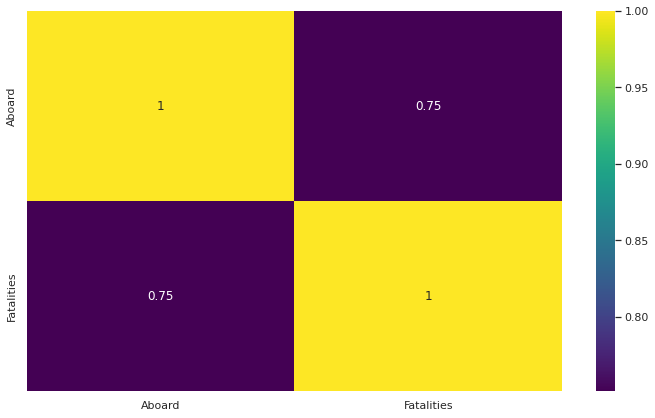

In [ ]:
plt.figure(figsize=(12,7))
sns.heatmap(df_temp.corr(),annot=True,cmap='viridis')

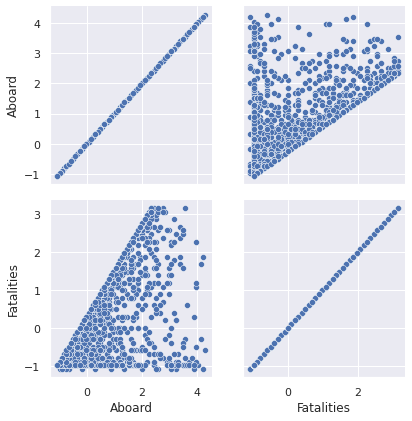

In [ ]:
g = sns.PairGrid(df_temp, height=3)
g.map(sns.scatterplot)

In [ ]:
# Nhìn vào các chỉ số qua hàm descrie() và heatmap ta thấy 2 thuộc tính Aboard và Fatalities có độ tương quan với nhau cao
# => Ta sẽ drop thuộc tính Aboard
# Bài toán sẽ chuyển thành: Dựa vào số lượng người chết trên máy bay để xác định mức độ thương vong của vụ tai nạn
#df_temp = df_temp.drop('Aboard', axis = 1)
#df_temp

# KNN CLASSIFIER

In [ ]:
from sklearn.model_selection import train_test_split
  
X_train, X_test, y_train, y_test = train_test_split(df_scale, df['y'], test_size = 0.30)
  
from sklearn.neighbors import KNeighborsClassifier
  
knn = KNeighborsClassifier(n_neighbors = 1)
  
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
  

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, pred))
  
print(classification_report(y_test, pred))

[[ 77   0  24]
 [  0 348 119]
 [ 20 110 578]]
              precision    recall  f1-score   support

           0       0.79      0.76      0.78       101
           1       0.76      0.75      0.75       467
           2       0.80      0.82      0.81       708

    accuracy                           0.79      1276
   macro avg       0.79      0.77      0.78      1276
weighted avg       0.79      0.79      0.79      1276



Text(0, 0.5, 'Error Rate')

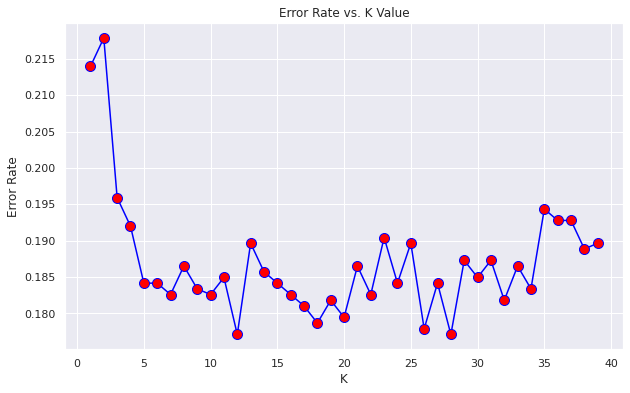

In [ ]:
error_rate = []
  
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
  
plt.figure(figsize =(10, 6))
plt.plot(range(1, 40), error_rate, color ='blue', linestyle ='-', marker ='o', markerfacecolor ='red', markersize = 10)

plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
  
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
  
print('WITH K = 3')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))
  
#Dựa vào Errorate, ta chọn K=9
# NOW WITH K = 9
knn = KNeighborsClassifier(n_neighbors = 9)
  
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
  
print('WITH K = 9')
print('\n')
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

WITH K = 3


[[ 80   0  21]
 [  0 368  99]
 [  9 121 578]]


              precision    recall  f1-score   support

           0       0.90      0.79      0.84       101
           1       0.75      0.79      0.77       467
           2       0.83      0.82      0.82       708

    accuracy                           0.80      1276
   macro avg       0.83      0.80      0.81      1276
weighted avg       0.81      0.80      0.80      1276

WITH K = 9


[[ 81   0  20]
 [  0 370  97]
 [  5 112 591]]


              precision    recall  f1-score   support

           0       0.94      0.80      0.87       101
           1       0.77      0.79      0.78       467
           2       0.83      0.83      0.83       708

    accuracy                           0.82      1276
   macro avg       0.85      0.81      0.83      1276
weighted avg       0.82      0.82      0.82      1276



**Detect Overfitting**

In [ ]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)


In [ ]:
strtfdKFold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=2)
kfold = strtfdKFold.split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
  knn.fit(X_train.iloc[train, :],y_train.iloc[train])
  y_pred = knn.predict(X_train.iloc[test, :])
  score=accuracy_score(y_train.iloc[test], y_pred)
  scores.append(score)
  print('\n\nFold: %2d, Training/Test Split Distribution: %s/%s, Accuracy: %.3f'%(k+1,np.bincount(y_train.iloc[train]),np.bincount(y_train.iloc[test]),score))
print('\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))



Fold:  1, Training/Test Split Distribution: [ 226 1005 1447]/[ 26 110 162], Accuracy: 0.846


Fold:  2, Training/Test Split Distribution: [ 225  994 1459]/[ 27 121 150], Accuracy: 0.872


Fold:  3, Training/Test Split Distribution: [ 228 1005 1445]/[ 24 110 164], Accuracy: 0.842


Fold:  4, Training/Test Split Distribution: [ 235  999 1444]/[ 17 116 165], Accuracy: 0.819


Fold:  5, Training/Test Split Distribution: [ 224 1012 1442]/[ 28 103 167], Accuracy: 0.819


Fold:  6, Training/Test Split Distribution: [ 227 1001 1450]/[ 25 114 159], Accuracy: 0.799


Fold:  7, Training/Test Split Distribution: [ 225 1002 1452]/[ 27 113 157], Accuracy: 0.781


Fold:  8, Training/Test Split Distribution: [ 227 1013 1439]/[ 25 102 170], Accuracy: 0.828


Fold:  9, Training/Test Split Distribution: [ 231  995 1453]/[ 21 120 156], Accuracy: 0.862


Fold: 10, Training/Test Split Distribution: [ 220 1009 1450]/[ 32 106 159], Accuracy: 0.835

Cross-Validation accuracy: 0.830 +/- 0.026


In [ ]:
#Ta thấy accuracy trung bình của tập train không chênh lệch nhiều so với độ đo của mô hình => Không bị over fitting

# LOGISTIC REGRESSION CLASSIFIER

In [ ]:
modelData = df.drop(['Operator', 'Type', 'Year', 'Month', 'Day', 'Hour', 'Minute'], axis = 1)

modelData

,Aboard,Fatalities,y
0,2.0,1.0,1
1,5.0,5.0,2
2,1.0,1.0,1
3,20.0,14.0,2
4,30.0,30.0,0
...,...,...,...
5260,11.0,1.0,1
5261,7.0,7.0,2
5262,18.0,18.0,2
5266,1.0,1.0,1


In [ ]:
# input
x = modelData.iloc[:, [0, 1]]


# output
y = modelData['y']

y

0       1
1       2
2       1
3       2
4       0
       ..
5260    1
5261    2
5262    2
5266    1
5267    2
Name: y, Length: 4252, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size = 0.3, random_state = 0)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaleData = StandardScaler()
X_train = scaleData.fit_transform(X_train) 
X_test = scaleData.transform(X_test)
X_train = pd.DataFrame(X_train, columns=x.columns)
X_test = pd.DataFrame(X_test, columns=x.columns)

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(random_state=0)

In [ ]:
y_pred = classifier.predict(X_test)


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
  
print ("Confusion Matrix : \n", cm)
print(classification_report(y_test, y_pred))

Confusion Matrix : 
 [[100   0   0]
 [  0 469   1]
 [  4   0 702]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       100
           1       1.00      1.00      1.00       470
           2       1.00      0.99      1.00       706

    accuracy                           1.00      1276
   macro avg       0.99      1.00      0.99      1276
weighted avg       1.00      1.00      1.00      1276



In [ ]:
from sklearn.metrics import accuracy_score
print ("Accuracy : ", accuracy_score(y_test, y_pred))

Accuracy :  0.9960815047021944


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with

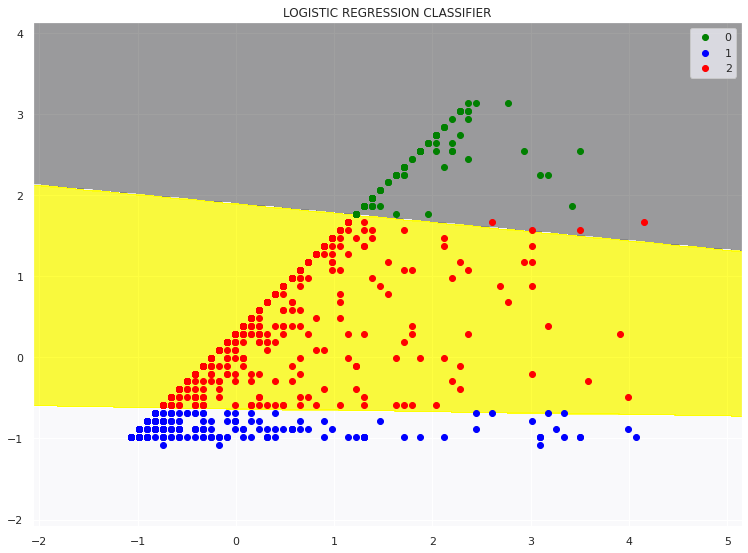

In [ ]:

from matplotlib.colors import ListedColormap
X_set, y_set = X_test.to_numpy(), y_test.to_numpy()
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, 
                               stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, 
                               stop = X_set[:, 1].max() + 1, step = 0.01))
  
plt.contourf(X1, X2, classifier.predict(
             np.array([X1.ravel(), X2.ravel()]).T).reshape(
             X1.shape), alpha = 0.75, cmap = ListedColormap(('gray', 'white','yellow')))
  
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
  
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('green', 'blue','red'))(i), label = j)
      
plt.title('LOGISTIC REGRESSION CLASSIFIER')
plt.xlabel('')
plt.ylabel('')
plt.legend()
plt.show()

**Detect Overfitting**

In [ ]:
strtfdKFold = RepeatedKFold(n_splits=10, n_repeats=1, random_state=2)
kfold = strtfdKFold.split(X_train, y_train)
scores = []
for k, (train, test) in enumerate(kfold):
  classifier.fit(X_train.iloc[train, :],y_train.iloc[train])
  y_pred = classifier.predict(X_train.iloc[test, :])
  score=accuracy_score(y_train.iloc[test], y_pred)
  scores.append(score)
  print('\n\nFold: %2d, Training/Test Split Distribution: %s/%s, Accuracy: %.3f'%(k+1,np.bincount(y_train.iloc[train]),np.bincount(y_train.iloc[test]),score))
print('\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))



Fold:  1, Training/Test Split Distribution: [ 230  989 1459]/[ 23 123 152], Accuracy: 0.997


Fold:  2, Training/Test Split Distribution: [ 224  996 1458]/[ 29 116 153], Accuracy: 1.000


Fold:  3, Training/Test Split Distribution: [ 229 1001 1448]/[ 24 111 163], Accuracy: 1.000


Fold:  4, Training/Test Split Distribution: [ 231  992 1455]/[ 22 120 156], Accuracy: 1.000


Fold:  5, Training/Test Split Distribution: [ 230  996 1452]/[ 23 116 159], Accuracy: 1.000


Fold:  6, Training/Test Split Distribution: [ 229 1003 1446]/[ 24 109 165], Accuracy: 1.000


Fold:  7, Training/Test Split Distribution: [ 224 1005 1450]/[ 29 107 161], Accuracy: 0.997


Fold:  8, Training/Test Split Distribution: [ 229 1005 1445]/[ 24 107 166], Accuracy: 1.000


Fold:  9, Training/Test Split Distribution: [ 230 1016 1433]/[ 23  96 178], Accuracy: 1.000


Fold: 10, Training/Test Split Distribution: [ 221 1005 1453]/[ 32 107 158], Accuracy: 0.976

Cross-Validation accuracy: 0.997 +/- 0.007


In [ ]:
#Ta thấy accuracy trung bình của tập train không chênh lệch nhiều so với độ đo của mô hình => Không bị over fitting